In [2]:
'''
get kaggle dataset
'''
!pip install -q kaggle
from google.colab import files
files.upload() #upload kaggle.json
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
# !kaggle datasets list
!kaggle competitions download -c titanic

Saving kaggle.json to kaggle (1).json
mkdir: cannot create directory ‘/root/.kaggle’: File exists
test.csv: Skipping, found more recently modified local copy (use --force to force download)
gender_submission.csv: Skipping, found more recently modified local copy (use --force to force download)
train.csv: Skipping, found more recently modified local copy (use --force to force download)


In [95]:
def data_preprocessing(data, mean, std):

  NEW_COLUMNS = ['Survived', 'Pclass', 'Age', 'Fare', 'Sex_female', 'Sex_male',
       'Parch_0', 'Parch_1', 'Parch_2', 'Parch_3', 'Parch_4', 'Parch_5',
       'Parch_6', 'Parch_9', 'SibSp_0', 'SibSp_1', 'SibSp_2', 'SibSp_3',
       'SibSp_4', 'SibSp_5', 'SibSp_8', 'Embarked_C', 'Embarked_Q', 'Embarked_S',
       'Cabin_A', 'Cabin_B', 'Cabin_C', 'Cabin_D', 'Cabin_E', 'Cabin_F',
       'Cabin_G', 'Cabin_T', 'Cabin_Z']

  data = data.drop(['PassengerId','Name','Ticket'], axis=1)

  # print(data.isna().any())
  #Age, Embarked have null value

  '''
  Sex, Parch, SibSp one-hot encoding
  '''
  data = data.join(pd.get_dummies(data.Sex, prefix="Sex"))
  data = data.drop(['Sex'], axis=1)
  data = data.join(pd.get_dummies(data.Parch, prefix="Parch"))
  data = data.drop(['Parch'],axis=1)
  data = data.join(pd.get_dummies(data.SibSp, prefix="SibSp"))
  data = data.drop(['SibSp'],axis=1)

  '''
  Fare, Age 標準化
  '''
  data['Fare'] = (data['Fare'] - mean['Fare']) / std['Fare']
  data['Age'] = (data['Age'] - mean['Age']) / std['Age']


  '''
  Embarked 缺失的值取眾數
  '''
  data['Embarked'].fillna(value=data['Embarked'].mode().values[0], inplace=True)
  # print(data.isna().any())
  data = data.join(pd.get_dummies(data.Embarked, prefix="Embarked"))
  data = data.drop(['Embarked'],axis=1)


  '''
  Cabin 空值填入 Z
  其餘取首字母
  '''
  data['Cabin'].fillna(value='Z', inplace=True)

  def cabin_map(x):
      return x[0]

  data['Cabin'] = data['Cabin'].map(cabin_map)
  data = data.join(pd.get_dummies(data.Cabin, prefix="Cabin"))
  data = data.drop(['Cabin'],axis=1)

  '''
  Age 取中位數
  '''
  # print('Age median: ', data['Age'].median())
  data['Age'].fillna(value=data['Age'].median(), inplace=True)
  # print(data.isna().any())


  data = pd.DataFrame(data, columns=NEW_COLUMNS)
  data = data.fillna(0)

  print(data)

  return data

     Survived  Pclass       Age      Fare  ...  Cabin_F  Cabin_G  Cabin_T  Cabin_Z
0           0       3 -0.530005 -0.502163  ...        0        0        0        1
1           1       1  0.571430  0.786404  ...        0        0        0        0
2           1       3 -0.254646 -0.488580  ...        0        0        0        1
3           1       1  0.364911  0.420494  ...        0        0        0        0
4           0       3  0.364911 -0.486064  ...        0        0        0        1
..        ...     ...       ...       ...  ...      ...      ...      ...      ...
886         0       2 -0.185807 -0.386454  ...        0        0        0        1
887         1       1 -0.736524 -0.044356  ...        0        0        0        0
888         0       3 -0.116967 -0.176164  ...        0        0        0        1
889         1       1 -0.254646 -0.044356  ...        0        0        0        0
890         0       3  0.158392 -0.492101  ...        0        0        0        1

[89

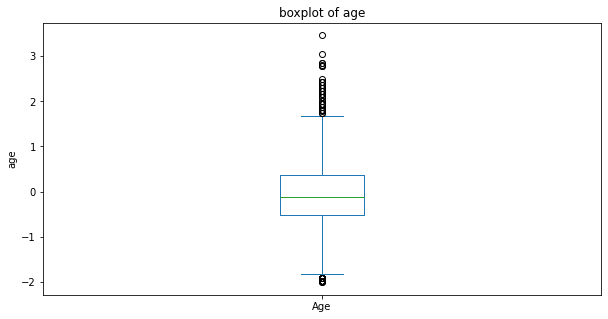

In [96]:
'''
get train/valid dataset
'''
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


data = pd.read_csv('train.csv')

'''
Age, Fare 會做標準化
'''
mean = {}
std = {}
mean['Fare'] = data['Fare'].mean()
std['Fare'] = data['Fare'].std()
mean['Age'] = data['Age'].mean()
std['Age'] = data['Age'].std()


data = data_preprocessing(data, mean, std)



print(data.columns)

model_data_columns = data.columns

chart = data['Age'].plot(kind='box',  
      title='boxplot of age',  
                xlabel='xlabel',  
                ylabel='age',  
                legend=True,  
                figsize=(10, 5))  
plt.show()

In [97]:
'''
分離出 train, valid 的輸入輸出
'''
train = data.sample(frac=0.7,random_state=12345)
valid = data.drop(train.index)

train_x = train.drop(labels=['Survived'],axis=1)
train_y = train['Survived']
valid_x = valid.drop(labels=['Survived'],axis=1)
valid_y = valid['Survived']

In [98]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
print(torch.__version__)

1.10.0+cu111


In [99]:
class NN(nn.Module):
  def __init__(self, input_dim):
    super().__init__()
    self.fc = nn.Sequential(
        nn.Linear(input_dim, 8),
        nn.ReLU(),
        nn.Linear(8, 16),
        # nn.BatchNorm1d(16),
        nn.ReLU(),
        nn.Linear(16, 2),
        nn.Softmax(dim=1)
    )

  def forward(self, input):
    out = self.fc(input)
    # print(out[0])
    return out

In [100]:
input_dims = 32

model = NN(input_dims)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('device: ',device)
model.to(device)

device:  cpu


NN(
  (fc): Sequential(
    (0): Linear(in_features=32, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=2, bias=True)
    (5): Softmax(dim=1)
  )
)

In [101]:
'''
hyperparameters
'''
epochs = 100
learning_rate = 0.001 
batch_size = 32
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 
criterion = nn.CrossEntropyLoss()

In [102]:
def tensor_to_one_hot(tensor, class_number, device):
  ones = torch.sparse.torch.eye(2).to(device)
  return ones.index_select(0,tensor)

In [103]:

train_inputs = torch.tensor(train_x.values.tolist()).to(device)

train_labels = torch.tensor(train_y.values.tolist()).to(device)
train_labels = tensor_to_one_hot(train_labels, 2, device)


valid_inputs = torch.tensor(valid_x.values.tolist()).to(device)

valid_labels = torch.tensor(valid_y.values.tolist()).to(device)
valid_labels = tensor_to_one_hot(valid_labels, 2, device)

train_dataset = TensorDataset(train_inputs, train_labels)
trainLoader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)


best_loss = 1000000000
best_accuracy = 0 

for epoch_index, epoch in enumerate(range(epochs), 0):
  model.train()
  for i, batch in enumerate(trainLoader, 0):
    inputs, labels = batch

    optimizer.zero_grad() 
    outputs = model(inputs) 
    loss = criterion(outputs, labels)
    loss.backward() 
    optimizer.step() 

    
  if  epoch_index % 1 == 0:
    print("epoches: ", epoch_index, "loss: ", loss.item())
    model.eval()
    with torch.no_grad():
      outputs = model(valid_inputs)
      loss = criterion(outputs, valid_labels)
      if loss < best_loss:
        best_loss = loss
        torch.save(model.state_dict(), "model.pk1") 
        _, predicted = torch.max(outputs, 1)
        _, ans = torch.max(valid_labels, 1)
        best_accuracy = ((predicted==ans).sum().item()) / ans.shape[0] * 100 
        
        
      print("valid - epoches: ", epoch_index, "loss: ", loss.item())
      _, predicted = torch.max(outputs, 1)
      _, ans = torch.max(valid_labels, 1)
      print('Accuracy in valid set: ', str(((predicted==ans).sum().item()) / ans.shape[0] * 100)+ '%')

print('best loss in valid: ', best_loss.item())
print('It\'s accuracy: ',best_accuracy) 

epoches:  0 loss:  0.6979764103889465
valid - epoches:  0 loss:  0.693153977394104
Accuracy in valid set:  40.44943820224719%
epoches:  1 loss:  0.6616331338882446
valid - epoches:  1 loss:  0.6635456085205078
Accuracy in valid set:  62.92134831460674%
epoches:  2 loss:  0.6746731400489807
valid - epoches:  2 loss:  0.6330610513687134
Accuracy in valid set:  62.92134831460674%
epoches:  3 loss:  0.6276618242263794
valid - epoches:  3 loss:  0.6146378517150879
Accuracy in valid set:  62.92134831460674%
epoches:  4 loss:  0.644357442855835
valid - epoches:  4 loss:  0.6029319763183594
Accuracy in valid set:  62.92134831460674%
epoches:  5 loss:  0.5327239632606506
valid - epoches:  5 loss:  0.5918945670127869
Accuracy in valid set:  68.16479400749064%
epoches:  6 loss:  0.6058549284934998
valid - epoches:  6 loss:  0.5810983777046204
Accuracy in valid set:  71.91011235955057%
epoches:  7 loss:  0.5459869503974915
valid - epoches:  7 loss:  0.5714897513389587
Accuracy in valid set:  73.78

In [104]:
model.load_state_dict(torch.load("model.pk1")) 
model.eval()


data = pd.read_csv('test.csv')
data = data_preprocessing(data, mean, std)
data = data.drop(['Survived'],axis=1)

test_input = torch.tensor(data.values.tolist()).to(device)
test_ans = torch.max(model(test_input),1)[1]
submission = pd.read_csv('./gender_submission.csv')
submission['Survived'] = test_ans.cpu()
submission.to_csv('./gender_submission.csv', index=False)

     Survived  Pclass       Age      Fare  ...  Cabin_F  Cabin_G  Cabin_T  Cabin_Z
0         0.0       3  0.330491 -0.490508  ...        0        0      0.0        1
1         0.0       3  1.190988 -0.507194  ...        0        0      0.0        1
2         0.0       2  2.223584 -0.453112  ...        0        0      0.0        1
3         0.0       3 -0.185807 -0.473739  ...        0        0      0.0        1
4         0.0       3 -0.530005 -0.400792  ...        0        0      0.0        1
..        ...     ...       ...       ...  ...      ...      ...      ...      ...
413       0.0       3 -0.185807 -0.486064  ...        0        0      0.0        1
414       0.0       1  0.640270  1.543379  ...        0        0      0.0        0
415       0.0       3  0.605850 -0.502163  ...        0        0      0.0        1
416       0.0       3 -0.185807 -0.486064  ...        0        0      0.0        1
417       0.0       3 -0.185807 -0.198133  ...        0        0      0.0        1

[41

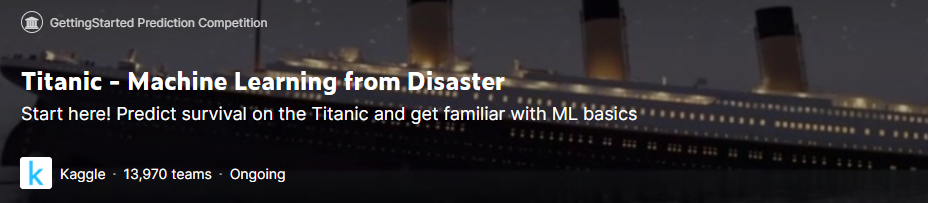
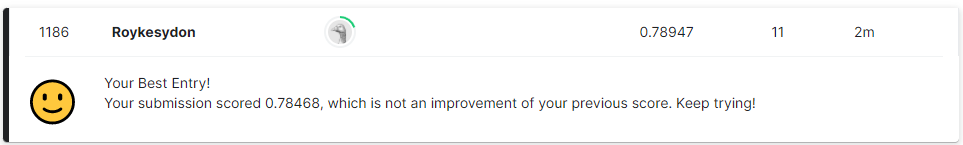